# Building a Spam Filter with Naive Bayes


Multinomial Naive Bayes is a popular algorithm for classifying categorical data. It was used in this project to build a spam filter. A model was trained on a subset of 5,572 SMS messages, to calculate the probability of them being spam and non-spam ('ham'), by using the Naive Bayes formula and probability values. From this information, a filter was developed and tested on the remaining subset of SMS messages, which classified them either as spam or ham depending on which probability was greater (based off the training dataset). 

This is the Multinomial Naive Bayes formula:

\begin{equation}
P(Spam | w_1,w_2, ..., w_n) \propto P(Spam) \cdot \prod_{i=1}^{n}P(w_i|Spam) \\
P(Ham | w_1,w_2, ..., w_n) \propto P(Ham) \cdot \prod_{i=1}^{n}P(w_i|Ham)
\end{equation}



### DataQuest Project Scope
This project was for the completion of the DataQuest.io https://www.dataquest.io/ "Conditional Probability" module; the eighteenth in a series for the completing Data Science course path. In this module students learned how to:

- Assign probabilities to events based on certain conditions by using conditional probability rules.
- Assign probabilities to events based on whether they are in relationship of statistical independence -or not with other events.
- Assign probabilities to events based on prior knowledge by using Bayes' theorem.
- Create a spam filter for SMS messages using the multinomial Naive Bayes algorithm.

### Results Summary
The model successfully classified whether a message was spam or non-spam('ham') with 98.7% accuracy. 

# Data Source and Exploration
The dataset was complied by Tiago A. Almeida and José María Gómez Hidalgo, and it can be downloaded from the The UCI Machine Learning Repository [here](https://archive.ics.uci.edu/ml/datasets/sms+spam+collection).
It contains 5,572 rows and two columns, which are as follows: 
- "Label": Contains only two categorical labels. Either "ham" or "spam"
- "SMS": The original message 

Begin by importing and exploring the data.

In [102]:
# Import pandas library and dataset
import pandas as pd
data = pd.read_csv('SMSSpamCollection', sep='\t', header = None, names = ['Label', 'SMS'])

In [103]:
# First 5 rows of dataset
data.head()

,Label,SMS
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [104]:
# Print the total number of rows and columns
data.shape

(5572, 2)

### Randomize and Split Datasets
The initial ham:spam proportion was observed to be ~0.86 ham to ~0.13 spam. The dataset was randomize and split into two new data frames: 80% of the rows were assigned for training the model; and the remaining 20% were reserved for testing the model. It was confirmed that the proportion of ham:spam messages were maintained after the split.  

In [105]:
# Check the proportions of ham:spam labels before randomizing and splitting
data['Label'].value_counts(normalize = True)

ham     0.865937
spam    0.134063
Name: Label, dtype: float64

In [106]:
# Randomize the data rows
random_set = data.sample(frac = 1, random_state = 1)
random_set.head()

,Label,SMS
1078,ham,"Yep, by the pretty sculpture"
4028,ham,"Yes, princess. Are you going to make me moan?"
958,ham,Welp apparently he retired
4642,ham,Havent.
4674,ham,I forgot 2 ask ü all smth.. There's a card on ...


In [107]:
# Split the first 80% of the rows into a training set, and the remaining 20% into a test set
# Reset the index
training = random_set.iloc[:4458].reset_index(drop = True)
test = random_set.iloc[4458:].reset_index(drop = True)
print('There are {} rows and {} columns in the training dataset.'.format(training.shape[0], training.shape[1]))
print('There are {} rows and {} columns in the test dataset.'.format(test.shape[0], test.shape[1]))

There are 4458 rows and 2 columns in the training dataset.
There are 1114 rows and 2 columns in the test dataset.


In [108]:
# Check the values counts of both sets to insure the ratios of ham to spam labels were preserved
train_ratio = training['Label'].value_counts(normalize = True)
test_ratio = test['Label'].value_counts(normalize = True)
print('The ratio ham:spam ratio for the training dataset is {:.2f} ham : {:.2f} spam. The ratio has been maintained.'.format(train_ratio[0],train_ratio[1]))
print('The ratio ham:spam ratio for the test dataset is {:.2f} ham : {:.2f} spam. The ratio has been maintained.'.format(test_ratio[0],test_ratio[1]))


The ratio ham:spam ratio for the training dataset is 0.87 ham : 0.13 spam. The ratio has been maintained.
The ratio ham:spam ratio for the test dataset is 0.87 ham : 0.13 spam. The ratio has been maintained.


# Cleaning the Training Data Set
It was prudent to get the training dataset into the format shown below in order to make computational iterations easier:

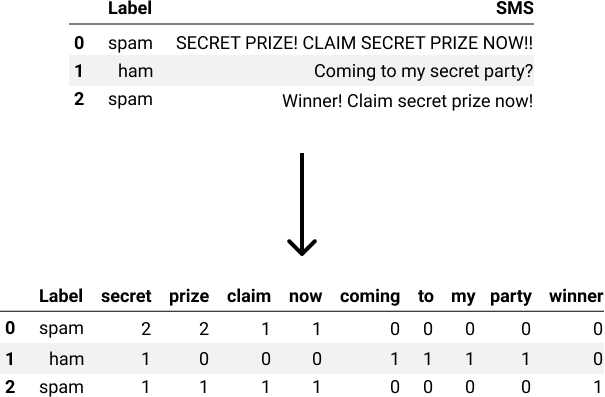

First, all the punctuation from the SMS messages were removed and the letters were set to lowercase. Then, a new, cleaned data frame was created with each word set as a column with the number of times it appeared in each SMS message. The vocabulary contained 7783 unique words, so the new cleaned training data frame had 7783 columns, and was in the same format as shown above.

In [109]:
# Remove punctuation and set to all letters to lowercase
training = training.copy()
training['SMS'] = training['SMS'].str.replace('\W', ' ', regex = True).str.lower()
training.head()

,Label,SMS
0,ham,yep by the pretty sculpture
1,ham,yes princess are you going to make me moan
2,ham,welp apparently he retired
3,ham,havent
4,ham,i forgot 2 ask ü all smth there s a card on ...


In [110]:
# Convert each message to a list of strings
training = training.copy()
training['SMS'] = training['SMS'].str.split()

In [111]:
# Print first 5 rows
training.head()

,Label,SMS
0,ham,"[yep, by, the, pretty, sculpture]"
1,ham,"[yes, princess, are, you, going, to, make, me,..."
2,ham,"[welp, apparently, he, retired]"
3,ham,[havent]
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,..."


In [112]:
# Create a vocabulary by iterating over the training SMS and saving each word to a list
vocabulary = []
for message in training['SMS']:
    for word in message:
        vocabulary.append(word)
voc_set = set(vocabulary)

In [113]:
# Find the number of words in the vocabulary
vocabulary = list(voc_set)
print('There are {} unique words in the vocabulary.'.format(len(vocabulary)))

There are 7783 unique words in the vocabulary.


In [114]:
# Create a frequency distribution for all the words using a dictionary
word_counts_per_sms = {unique_word:[0]*len(training['SMS']) for unique_word in vocabulary}
for index, sms in enumerate(training['SMS']):
    for word in sms:
        word_counts_per_sms[word][index] +=1

In [115]:
# Create a dataframe with each column as vocabulary word, with times it appears in a message
df_temp = pd.DataFrame(word_counts_per_sms)
df_temp.head()

,burger,airport,simpler,165,falling,kills,detroit,fne,telephone,user,...,09061743806,spell,planning,69696,jiu,dancin,atm,pobox365o4w45wq,stereo,faber
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [116]:
# Put the Label and SMS columns in front of the others. 
train_df = pd.concat([training, df_temp], axis = 1)
train_df.head()

,Label,SMS,burger,airport,simpler,165,falling,kills,detroit,fne,...,09061743806,spell,planning,69696,jiu,dancin,atm,pobox365o4w45wq,stereo,faber
0,ham,"[yep, by, the, pretty, sculpture]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ham,"[yes, princess, are, you, going, to, make, me,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ham,"[welp, apparently, he, retired]",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ham,[havent],0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ham,"[i, forgot, 2, ask, ü, all, smth, there, s, a,...",0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Calculating the  Parameters of Naive Bayes
Using the Multinomial Naive Bayes equation, in order to find:

\begin{equation}
P(Spam | w_1,w_2, ..., w_n) \\
P(Ham | w_1,w_2, ..., w_n) 
\end{equation}

Where:

P = probability

w = word in the message

We must first calculate P(wi|Spam) and P(wi|Ham):
  
\begin{equation}
P(w_i|Spam) = \frac{N_{w_i|Spam} + \alpha}{N_{Spam} + \alpha \cdot N_{Vocabulary}} \\
P(w_i|Ham) = \frac{N_{w_i|Ham} + \alpha}{N_{Ham} + \alpha \cdot N_{Vocabulary}}
\end{equation}

Where:

N = number

$\alpha$ = Laplace smoothing factor

The following are constants: 

\begin{equation}
\alpha = 1 \\
N_{Spam} \\
N_{Ham} \\
N_{Vocabulary}\\
\end{equation}

The following is a variable: 
\begin{equation}
N_{w_i|Spam} \end{equation}

The following code calculates all the parameters. 

In [117]:
# Create column that totals rows
train_df['total'] = train_df.iloc[:,2:].sum(axis= 1)

In [118]:
# Isolate spam and ham messages
filt_spam = train_df['Label'] == 'spam'
filt_ham = train_df['Label'] == 'ham'
spam_df = train_df[filt_spam]
ham_df = train_df[filt_ham]

In [119]:
# Calculate the parameters

# P(Spam) and P(Ham)
p_spam = len(spam_df)/(len(train_df))
p_ham  = len(ham_df)/(len(train_df))

# Find n_spam = number of words in all spam messages
spam_tot = train_df.loc[filt_spam]['total']
n_spam = sum(spam_tot)

# Find n_ham = number of words in all ham messages
ham_tot = train_df.loc[filt_ham]['total']
n_ham = sum(ham_tot)

# Find n_vocabulary = number of words all total
n_vocabulary = len(vocabulary)

# Initiate variable for Laplace smoothing = 1
alpha = 1

In [120]:
# calculate P(wi|Spam) and P(wi|Ham)
p_w_given_spam = {}
p_w_given_ham = {}

def p_word_given_am(dataframe, n_am, word): 
    # Takes spam or ham dataframe, n_spam or n_ham parameter, and vocabulary word.
    # Calculates the sum of column labeled for the given vocabulary word
    # Calculates P(wi|Spam) and P(wi|Ham) per the formula above 
    word_sum = dataframe[word].sum() 
    p_am = (word_sum + alpha) /(n_am + (alpha*n_vocabulary)) 
    return p_am # Returns the results

# Populates a dictionary with the word as a key and P(wi|Spam) and P(wi|Ham) as the values.
for word in (vocabulary): 
    p_w_given_spam[word] = p_word_given_am(spam_df, n_spam, word)
    p_w_given_ham[word] = p_word_given_am(ham_df, n_ham, word)

# Building the Spam Filter
The final calculation in the Naive Bayes formula was to multiply P(Ham) and P(Spam) with P(wi|Spam) and P(wi|Ham) respectively for each message that came into the spam filter. These variables change with each message, so they are calculated in real time. The result is a probability calculation for each message, which gets sorted based on whether it's more likely to be spam or non-spam(ham). 

In [121]:
# Determine if a message is more likely to be spam or ham

import re
import numpy as np

def classify(message): # takes in the message
    # Cleans the message:
    message = re.sub('\W', ' ', message) 
    message = message.lower()            
    message = message.split()            

    # Compares each word to the dictionaries in the last step and collects the values into new lists
    spam_list = []
    ham_list = []
    for word in message:     
        if word in p_w_given_spam:
            spam_list.append(p_w_given_spam[word]) 
        if word in p_w_given_ham:
            ham_list.append(p_w_given_ham[word])

    # Gets the product of each list          
    spam_prod = np.prod(spam_list)
    ham_prod = np.prod(ham_list)
    
    # Multiplies the products above by P(Spam) and P(Ham)
    p_spam_given_message =  spam_prod * p_spam
    p_ham_given_message =  ham_prod * p_ham

    # Labeles the message 'ham' or 'spam' based on the higher probability
    if p_ham_given_message > p_spam_given_message:
        return 'ham'
    elif p_spam_given_message > p_ham_given_message:
        return 'spam'
    else:
        return 'needs human classification'

### Testing the Model with Know Classifications
The following two messages are known to be spam and ham respectively. They were tested with the model above, and the outcome revealed that they were correctly classified. 

In [122]:
spam_classify  = classify("WINNER!! This is the secret code to unlock the money: C3421.")
ham_classify = classify("Sounds good, Tom, then see u there")

print(spam_classify)
print(ham_classify)

spam
ham


### Testing the Model on the Entire Test Dataset
A new column 'predicted' was created in the test data frame to easily compare the actual 'Label' to the 'predicted' outcome from the model. The results below show the first five messages correctly classified. 

In [123]:
# Test the model on entire test dataset
test['predicted'] = test['SMS'].apply(classify)
test.head()

,Label,SMS,predicted
0,ham,Later i guess. I needa do mcat study too.,ham
1,ham,But i haf enuff space got like 4 mb...,ham
2,spam,Had your mobile 10 mths? Update to latest Oran...,spam
3,ham,All sounds good. Fingers . Makes it difficult ...,ham
4,ham,"All done, all handed in. Don't know if mega sh...",ham


# Conclusion

### Accuracy
To determine the accuracy of the test, we counted the number of messages where the 'Label' and the 'predicted' columns matched. Out of the 1114 messages in the test set, 1100 were accurately labeled. That is a 98.7% accuracy rate. 

In [124]:
# Determine the accuracy of the test
correct = 0
total = len(test)

for index, row in test.iterrows():
    if row['Label'] == row['predicted']:
        correct+=1
print('{} messages were labeled correctly.'.format(correct))
accuracy = correct/total*100
print('The accuracy of the spam filter is {:.1f}%.'.format(accuracy))

1100 messages were labeled correctly.
The accuracy of the spam filter is 98.7%.
